In [109]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('ggplot')

print("Loading and processing datasets...")

# 1. Load the datasets
weather_df = pd.read_csv('Tahoe_NOAA_Data.csv')
resort_df = pd.read_csv('Tahoe_Resort_Season_Dates.csv')
oni_df = pd.read_csv('NOAA_ONI_Data.csv')

Loading and processing datasets...


In [111]:
# 2. Process weather data
# Convert date to datetime
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])

# Extract date components
weather_df['YEAR'] = weather_df['DATE'].dt.year
weather_df['MONTH'] = weather_df['DATE'].dt.month
weather_df['DAY'] = weather_df['DATE'].dt.day
weather_df['DOY'] = weather_df['DATE'].dt.dayofyear  # Day of year

# Define winter season (July 1 to June 30)
weather_df['SEASON'] = weather_df['DATE'].apply(
    lambda x: f"{x.year}-{x.year+1}" if x.month >= 7 else f"{x.year-1}-{x.year}"
)

# Define winter day (days since November 1)
def winter_day(date):
    year = date.year
    nov1 = datetime(year, 11, 1)
    if date.month < 11:
        nov1 = datetime(year-1, 11, 1)
    return (date - nov1).days + 1

weather_df['WINTER_DAY'] = weather_df['DATE'].apply(winter_day)

# Calculate station elevation statistics
print("\nWeather station elevation statistics:")
elevation_stats = weather_df.groupby(['STATION', 'NAME'])['ELEVATION'].first().reset_index()
display(elevation_stats.describe())


Weather station elevation statistics:


,ELEVATION
count,7.000000
mean,1914.428571
std,165.184641
min,1699.300000
25%,1848.600000
50%,1907.000000
75%,1931.050000
max,2235.400000


In [113]:
# 3. Process resort opening/closing dates
# Convert dates to datetime
resort_df['OPENING_DATE'] = pd.to_datetime(resort_df['OPENING DATE'])
resort_df['CLOSING_DATE'] = pd.to_datetime(resort_df['CLOSING DATE'])
resort_df.drop(['OPENING DATE', 'CLOSING DATE'], axis=1, inplace=True)

# Calculate season length in days
resort_df['SEASON_LENGTH'] = (resort_df['CLOSING_DATE'] - resort_df['OPENING_DATE']).dt.days

# Extract opening/closing day of year
resort_df['OPENING_DOY'] = resort_df['OPENING_DATE'].dt.dayofyear
resort_df['CLOSING_DOY'] = resort_df['CLOSING_DATE'].dt.dayofyear

# Adjust closing DOY for seasons spanning year boundary
resort_df.loc[resort_df['CLOSING_DATE'].dt.year > resort_df['OPENING_DATE'].dt.year, 'CLOSING_DOY'] += 365

# Define ski season
resort_df['SKI_SEASON'] = resort_df['OPENING_DATE'].apply(
    lambda x: f"{x.year}-{x.year+1}" if x.month >= 7 else f"{x.year-1}-{x.year}"
)

print("\nResort season statistics:")
display(resort_df[['SEASON_LENGTH']].describe())

# Print opening/closing date ranges
print(f"Earliest opening date: {resort_df['OPENING_DATE'].min().strftime('%Y-%m-%d')}")
print(f"Latest opening date: {resort_df['OPENING_DATE'].max().strftime('%Y-%m-%d')}")
print(f"Earliest closing date: {resort_df['CLOSING_DATE'].min().strftime('%Y-%m-%d')}")
print(f"Latest closing date: {resort_df['CLOSING_DATE'].max().strftime('%Y-%m-%d')}")


Resort season statistics:


,SEASON_LENGTH
count,44.000000
mean,156.022727
std,31.679712
min,99.000000
25%,139.250000
50%,151.500000
75%,173.750000
max,234.000000


Earliest opening date: 2014-11-21
Latest opening date: 2024-11-29
Earliest closing date: 2015-03-21
Latest closing date: 2025-06-03


In [115]:
# 4. Process ONI (El Niño/La Niña) data
# Reshape from wide to long format
oni_long = pd.melt(oni_df, id_vars=['Year'], 
                   value_vars=['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 
                               'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ'],
                   var_name='Month_Group', value_name='ONI')

# Create mapping for central month of each 3-month group
month_mapping = {
    'DJF': 1,   # January
    'JFM': 2,   # February
    'FMA': 3,   # March
    'MAM': 4,   # April
    'AMJ': 5,   # May
    'MJJ': 6,   # June
    'JJA': 7,   # July
    'JAS': 8,   # August
    'ASO': 9,   # September
    'SON': 10,  # October
    'OND': 11,  # November
    'NDJ': 12   # December
}

# Add month number
oni_long['Month'] = oni_long['Month_Group'].map(month_mapping)

# Create date for first day of the central month
oni_long['Date'] = pd.to_datetime(oni_long.apply(
    lambda x: f"{x['Year']}-{x['Month']}-01" if x['Month'] < 12 
              else f"{x['Year']-1}-{x['Month']}-01", axis=1))

# Sort by date
oni_long = oni_long.sort_values('Date').reset_index(drop=True)

In [117]:
# 5. Create a season-level ONI dataset (NEW)
# For each ski season (Nov-Apr), calculate average ONI
oni_long['SKI_SEASON'] = oni_long['Date'].apply(
    lambda x: f"{x.year}-{x.year+1}" if x.month >= 7 else f"{x.year-1}-{x.year}"
)

# Calculate seasonal ONI averages (winter months: Nov-Apr)
winter_months = [11, 12, 1, 2, 3, 4]
oni_seasonal = oni_long[oni_long['Month'].isin(winter_months)].groupby('SKI_SEASON')['ONI'].mean().reset_index()
oni_seasonal.rename(columns={'ONI': 'SEASONAL_ONI'}, inplace=True)

In [119]:
# 6. Feature Engineering for Weather Data
print("\nPerforming feature engineering...")

# Group by station and date
station_daily = weather_df.groupby(['STATION', 'DATE']).agg({
    'PRCP': 'mean',
    'SNOW': 'mean',
    'SNWD': 'mean',
    'TMAX': 'mean',
    'TMIN': 'mean',
    'TAVG': lambda x: pd.to_numeric(x, errors='coerce').mean(),
    'YEAR': 'first',
    'MONTH': 'first',
    'DAY': 'first',
    'DOY': 'first',
    'SEASON': 'first',
    'WINTER_DAY': 'first'
}).reset_index()

# Create a date range spanning the entire dataset
date_range = pd.date_range(start=weather_df['DATE'].min(), end=weather_df['DATE'].max(), freq='D')
all_stations = weather_df['STATION'].unique()

# Create a complete dataframe with all dates for all stations
date_stations = pd.MultiIndex.from_product([all_stations, date_range], names=['STATION', 'DATE'])
complete_df = pd.DataFrame(index=date_stations).reset_index()

# Merge with the actual data
complete_df = complete_df.merge(station_daily, on=['STATION', 'DATE'], how='left')

# Fill in missing year, month, day values for dates without data
complete_df['YEAR'] = complete_df['YEAR'].fillna(complete_df['DATE'].dt.year)
complete_df['MONTH'] = complete_df['MONTH'].fillna(complete_df['DATE'].dt.month)
complete_df['DAY'] = complete_df['DAY'].fillna(complete_df['DATE'].dt.day)
complete_df['DOY'] = complete_df['DOY'].fillna(complete_df['DATE'].dt.dayofyear)

# Fill in missing SEASON values
complete_df['SEASON'] = complete_df['SEASON'].fillna(complete_df['DATE'].apply(
    lambda x: f"{x.year}-{x.year+1}" if x.month >= 7 else f"{x.year-1}-{x.year}"
))

# Calculate WINTER_DAY if missing
complete_df['WINTER_DAY'] = complete_df['WINTER_DAY'].fillna(complete_df['DATE'].apply(winter_day))


Performing feature engineering...


In [121]:
# 7. Create rolling window statistics
# For each station, calculate rolling metrics
for window in [7, 14, 30]:
    # Group by station to perform rolling calculations within each station
    for station in all_stations:
        station_mask = complete_df['STATION'] == station
        station_data = complete_df[station_mask].sort_values('DATE')
        
        # Calculate rolling averages
        complete_df.loc[station_mask, f'TMAX_{window}d_AVG'] = station_data['TMAX'].rolling(window, min_periods=1).mean()
        complete_df.loc[station_mask, f'TMIN_{window}d_AVG'] = station_data['TMIN'].rolling(window, min_periods=1).mean()
        
        # Calculate cumulative precipitation and snow
        complete_df.loc[station_mask, f'PRCP_{window}d_SUM'] = station_data['PRCP'].rolling(window, min_periods=1).sum()
        complete_df.loc[station_mask, f'SNOW_{window}d_SUM'] = station_data['SNOW'].rolling(window, min_periods=1).sum()
        
        # Calculate number of freeze days in rolling window
        complete_df.loc[station_mask, f'FREEZE_DAYS_{window}d'] = station_data['TMIN'].rolling(window, min_periods=1).apply(
            lambda x: (x <= 32).sum())

In [123]:
# 8. Calculate seasonal cumulative values
# Group by station and season
seasonal_groups = complete_df.groupby(['STATION', 'SEASON'])

# Initialize columns for cumulative seasonal values
complete_df['CUM_SNOW'] = np.nan
complete_df['CUM_PRCP'] = np.nan
complete_df['DAYS_BELOW_FREEZING'] = np.nan

# Calculate cumulative values within each season for each station
for (station, season), group in seasonal_groups:
    group = group.sort_values('DATE')
    mask = (complete_df['STATION'] == station) & (complete_df['SEASON'] == season)
    
    # Cumulative snow and precipitation for the season
    complete_df.loc[mask, 'CUM_SNOW'] = group['SNOW'].fillna(0).cumsum()
    complete_df.loc[mask, 'CUM_PRCP'] = group['PRCP'].fillna(0).cumsum()
    
    # Count of days below freezing in the season so far
    complete_df.loc[mask, 'DAYS_BELOW_FREEZING'] = group['TMIN'].fillna(100).apply(
        lambda x: 1 if x <= 32 else 0).cumsum()

In [125]:
# 9. Merge monthly ONI data with weather data
# Create month-year identifier for weather data
complete_df['YearMonth'] = complete_df['DATE'].dt.to_period('M')
oni_long['YearMonth'] = oni_long['Date'].dt.to_period('M')

# Merge ONI values
complete_df = complete_df.merge(oni_long[['YearMonth', 'ONI']], on='YearMonth', how='left')

In [127]:
# 10. Add ski season identifier to match with seasonal ONI (NEW)
complete_df['SKI_SEASON'] = complete_df['DATE'].apply(
    lambda x: f"{x.year}-{x.year+1}" if x.month >= 7 else f"{x.year-1}-{x.year}"
)

# Merge seasonal ONI values
complete_df = complete_df.merge(oni_seasonal, on='SKI_SEASON', how='left')

# Clean up intermediate columns
complete_df.drop('YearMonth', axis=1, inplace=True)

In [129]:
# 11. Aggregate across all stations for each date
# Since we want one row per date, average across all stations
daily_avg = complete_df.groupby('DATE').agg({
    'PRCP': 'mean',
    'SNOW': 'mean',
    'SNWD': 'mean',
    'TMAX': 'mean',
    'TMIN': 'mean',
    'TAVG': 'mean',
    'TMAX_7d_AVG': 'mean',
    'TMIN_7d_AVG': 'mean',
    'PRCP_7d_SUM': 'mean',
    'SNOW_7d_SUM': 'mean',
    'FREEZE_DAYS_7d': 'mean',
    'TMAX_14d_AVG': 'mean',
    'TMIN_14d_AVG': 'mean',
    'PRCP_14d_SUM': 'mean',
    'SNOW_14d_SUM': 'mean',
    'FREEZE_DAYS_14d': 'mean',
    'TMAX_30d_AVG': 'mean',
    'TMIN_30d_AVG': 'mean',
    'PRCP_30d_SUM': 'mean',
    'SNOW_30d_SUM': 'mean',
    'FREEZE_DAYS_30d': 'mean',
    'CUM_SNOW': 'mean',
    'CUM_PRCP': 'mean',
    'DAYS_BELOW_FREEZING': 'mean',
    'YEAR': 'first',
    'MONTH': 'first',
    'DAY': 'first',
    'DOY': 'first',
    'SEASON': 'first',
    'WINTER_DAY': 'first',
    'ONI': 'first',
    'SKI_SEASON': 'first',
    'SEASONAL_ONI': 'first'
}).reset_index()

In [135]:
# 12. Calculate ACTUAL seasonal snow totals for each resort/season (NEW)
print("\nCalculating actual seasonal snow totals...")

# Create a dictionary to store total seasonal snow for each resort/season
seasonal_totals = {}

# For each resort and season
for _, row in resort_df.iterrows():
    resort = row['Resort']
    season = row['Season']
    opening_date = row['OPENING_DATE']
    closing_date = row['CLOSING_DATE']
    
    # Get weather data for the entire season (opening to closing)
    season_weather = daily_avg[(daily_avg['DATE'] >= opening_date) & 
                               (daily_avg['DATE'] <= closing_date)]
    
    # Calculate total snowfall, precipitation, and freezing days for the season
    if len(season_weather) > 0:
        total_snow = season_weather['SNOW'].fillna(0).sum()
        total_prcp = season_weather['PRCP'].fillna(0).sum()
        freeze_days = (season_weather['TMIN'] <= 32).sum()
        avg_tmax = season_weather['TMAX'].mean()
        avg_tmin = season_weather['TMIN'].mean()
        
        # Get average ONI for the season
        season_oni = season_weather['SEASONAL_ONI'].mean()
        
        # Store in dictionary
        seasonal_totals[(resort, season)] = {
            'TOTAL_SNOW': total_snow,
            'TOTAL_PRCP': total_prcp,
            'FREEZE_DAYS': freeze_days,
            'AVG_TMAX': avg_tmax,
            'AVG_TMIN': avg_tmin,
            'SEASON_ONI': season_oni
        }


Calculating actual seasonal snow totals...


In [137]:
# 13. Create a dataset for exploring pre-season conditions (NEW)
print("\nPreparing seasonal analysis dataset...")

# Create a dataframe with pre-season conditions for each resort/season
pre_season_data = []

for _, row in resort_df.iterrows():
    resort = row['Resort']
    season = row['Season']
    opening_date = row['OPENING_DATE']
    closing_date = row['CLOSING_DATE']
    season_length = row['SEASON_LENGTH']
    
    # Get Nov 1 of that season
    year = opening_date.year
    if opening_date.month < 7:
        year = year - 1
    nov1 = datetime(year, 11, 1)
    
    # Get pre-season conditions (Nov 1 to opening date)
    preseason = daily_avg[(daily_avg['DATE'] >= nov1) & 
                          (daily_avg['DATE'] < opening_date)]
    
    if len(preseason) > 0:
        # Calculate pre-season metrics
        preseason_snow = preseason['SNOW'].fillna(0).sum()
        preseason_prcp = preseason['PRCP'].fillna(0).sum()
        preseason_freeze_days = (preseason['TMIN'] <= 32).sum()
        
        # Get the most recent snow depth before opening
        last_day = preseason.iloc[-1]
        snow_depth_at_opening = last_day['SNWD']
        
        # Get seasonal ONI value
        season_oni = last_day['SEASONAL_ONI']
        
        # Get season totals if available
        total_metrics = seasonal_totals.get((resort, season), {})
        
        # Create entry
        pre_season_data.append({
            'Resort': resort,
            'Season': season,
            'Opening_Date': opening_date,
            'Closing_Date': closing_date,
            'Season_Length': season_length,
            'Preseason_Snow': preseason_snow,
            'Preseason_Prcp': preseason_prcp,
            'Preseason_Freeze_Days': preseason_freeze_days,
            'Snow_Depth_At_Opening': snow_depth_at_opening,
            'Seasonal_ONI': season_oni,
            'Total_Season_Snow': total_metrics.get('TOTAL_SNOW', np.nan),
            'Total_Season_Prcp': total_metrics.get('TOTAL_PRCP', np.nan),
            'Season_Freeze_Days': total_metrics.get('FREEZE_DAYS', np.nan),
            'Season_Avg_Tmax': total_metrics.get('AVG_TMAX', np.nan),
            'Season_Avg_Tmin': total_metrics.get('AVG_TMIN', np.nan)
        })

# Convert to dataframe
seasonal_df = pd.DataFrame(pre_season_data)


Preparing seasonal analysis dataset...


In [139]:
# 14. Train a model to predict season length using seasonal data
print("\nTraining models for ski resort season prediction...")

# Define features and target
X_features = ['Preseason_Snow', 'Preseason_Freeze_Days', 'Snow_Depth_At_Opening', 
              'Seasonal_ONI', 'Preseason_Prcp']
y_target = 'Season_Length'

# One-hot encode the resort
X_with_resort = pd.get_dummies(seasonal_df, columns=['Resort'], prefix=['Resort'])

# Get all columns that are either features or resort indicators
resort_cols = [col for col in X_with_resort.columns if col.startswith('Resort_')]
all_features = X_features + resort_cols

# Drop rows with missing target values
model_data = X_with_resort.dropna(subset=[y_target] + X_features)

# Define X and y
X = model_data[all_features]
y = model_data[y_target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_preds = rf_model.predict(X_test_scaled)

# Evaluate
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

print("\nRandom Forest Model for Season Length Prediction:")
print(f"RMSE: {rf_rmse:.2f} days")
print(f"MAE: {rf_mae:.2f} days")
print(f"R² Score: {rf_r2:.2f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 most important features:")
display(feature_importance.head(10))


Training models for ski resort season prediction...

Random Forest Model for Season Length Prediction:
RMSE: 25.25 days
MAE: 18.88 days
R² Score: 0.44

Top 10 most important features:


,Feature,Importance
1,Preseason_Freeze_Days,0.383852
7,Resort_Palisades,0.251836
4,Preseason_Prcp,0.116505
3,Seasonal_ONI,0.084230
0,Preseason_Snow,0.080792
2,Snow_Depth_At_Opening,0.064219
6,Resort_Kirkwood,0.008378
8,Resort_Sugar Bowl,0.006473
5,Resort_Heavenly,0.003714


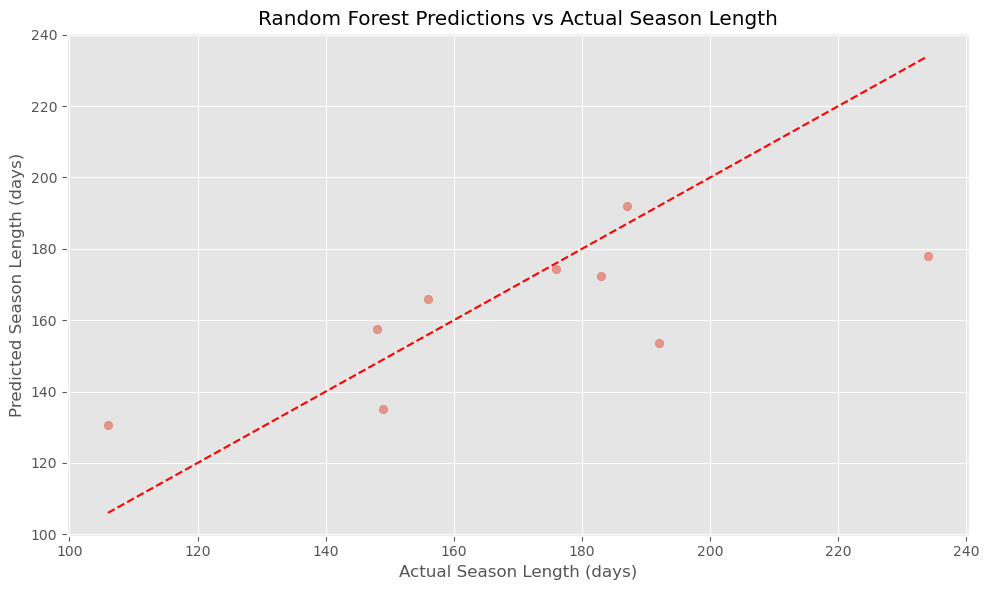

In [141]:
# 15. Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Season Length (days)')
plt.ylabel('Predicted Season Length (days)')
plt.title('Random Forest Predictions vs Actual Season Length')
plt.tight_layout()
plt.show()

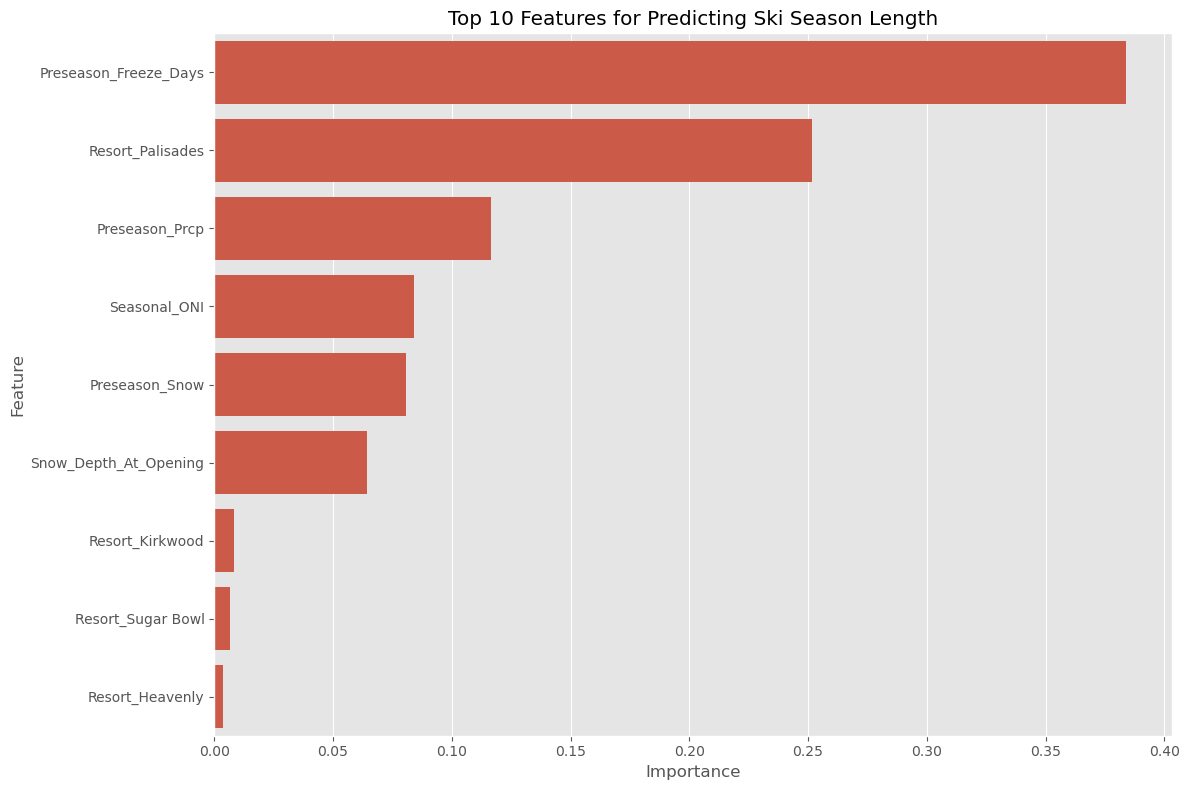

In [143]:
# 16. Feature importance plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Features for Predicting Ski Season Length')
plt.tight_layout()
plt.show()

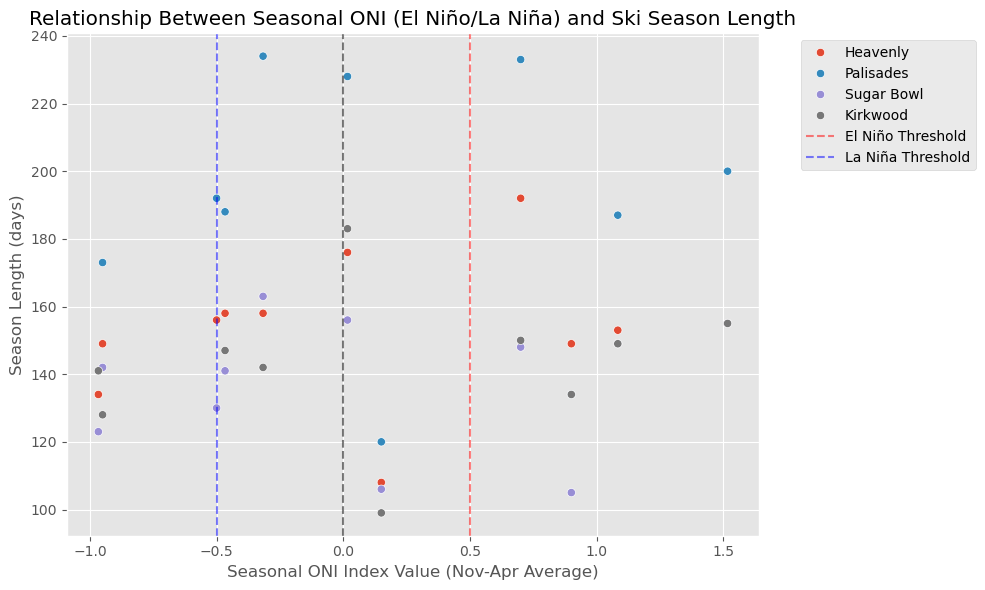

In [145]:
# 17. Visualize relationship between seasonal ONI and season length (REVISED)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Seasonal_ONI', y='Season_Length', hue='Resort', data=seasonal_df)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='El Niño Threshold')
plt.axvline(x=-0.5, color='blue', linestyle='--', alpha=0.5, label='La Niña Threshold')
plt.title('Relationship Between Seasonal ONI (El Niño/La Niña) and Ski Season Length')
plt.xlabel('Seasonal ONI Index Value (Nov-Apr Average)')
plt.ylabel('Season Length (days)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

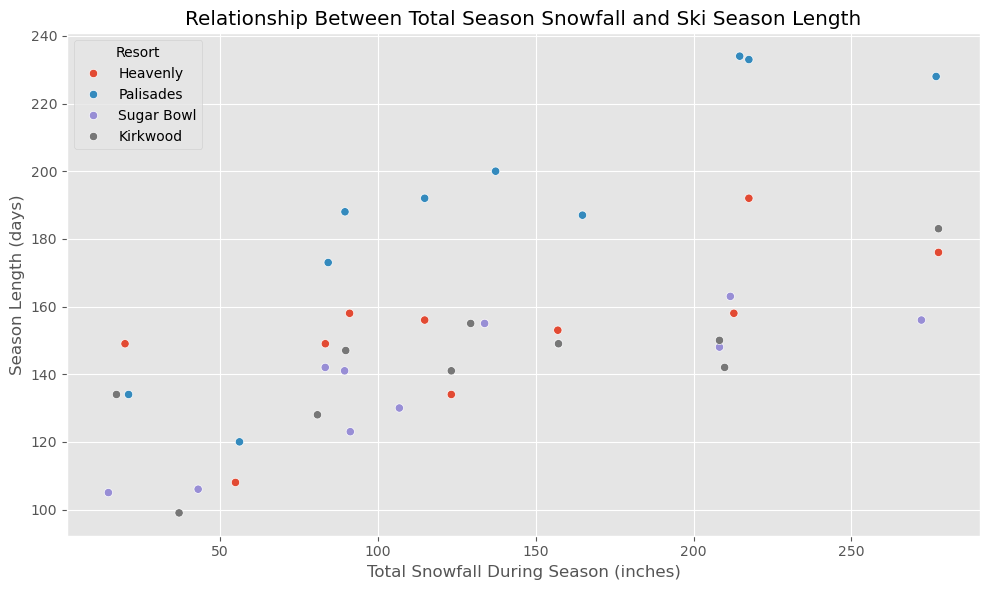

In [147]:
# 18. Visualize TOTAL seasonal snow vs season length (REVISED)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total_Season_Snow', y='Season_Length', hue='Resort', data=seasonal_df)
plt.title('Relationship Between Total Season Snowfall and Ski Season Length')
plt.xlabel('Total Snowfall During Season (inches)')
plt.ylabel('Season Length (days)')
plt.tight_layout()
plt.show()

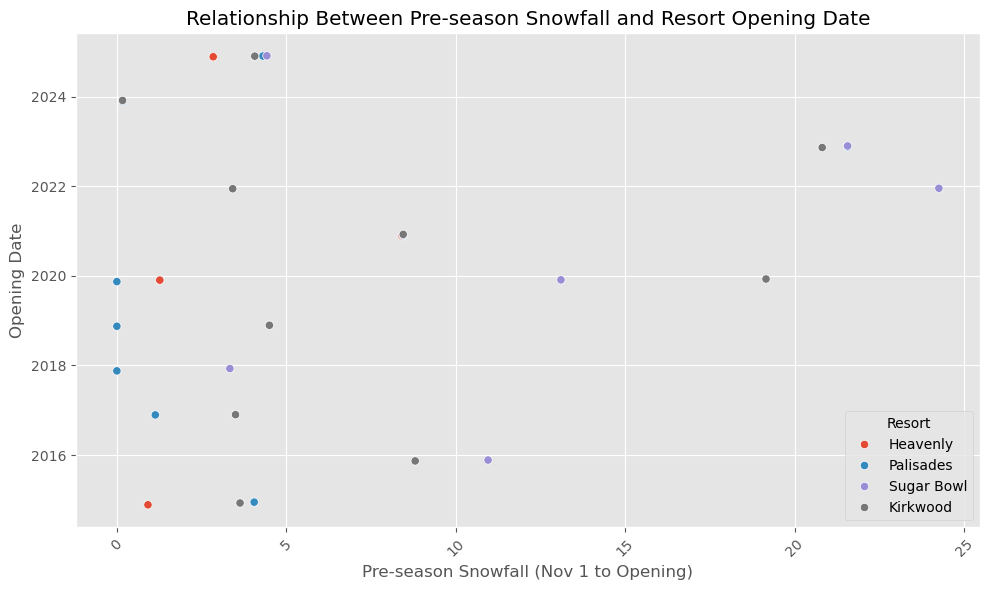

In [149]:
# 19. Visualize pre-season snow vs opening date
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Preseason_Snow', y='Opening_Date', hue='Resort', data=seasonal_df)
plt.title('Relationship Between Pre-season Snowfall and Resort Opening Date')
plt.xlabel('Pre-season Snowfall (Nov 1 to Opening)')
plt.ylabel('Opening Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

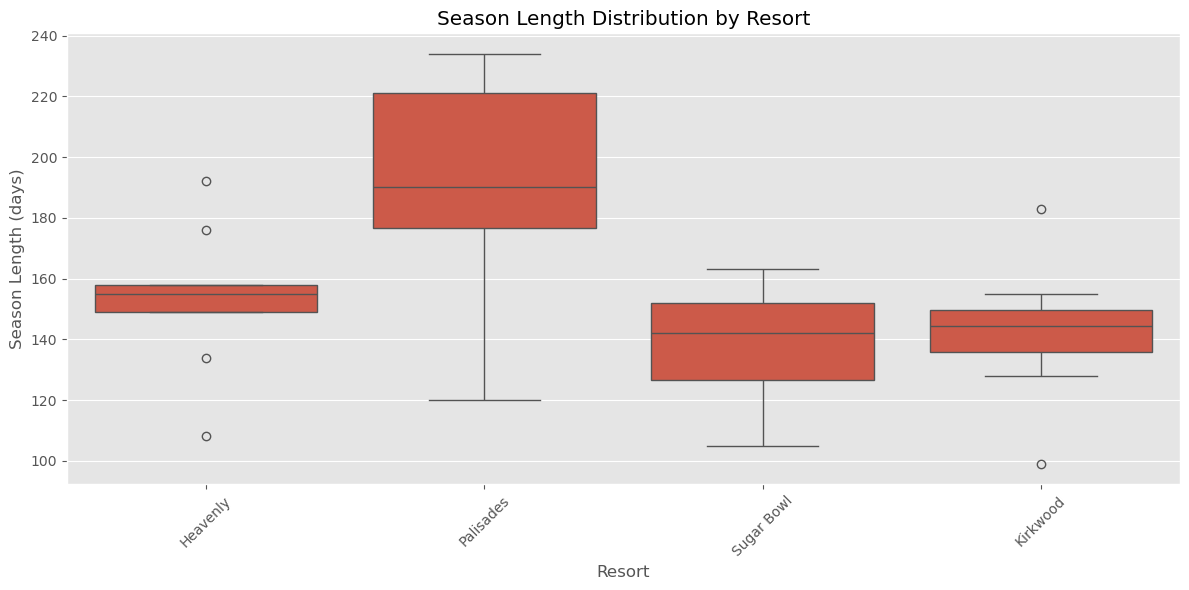

In [151]:
# 20. Season length by resort
plt.figure(figsize=(12, 6))
sns.boxplot(x='Resort', y='Season_Length', data=seasonal_df)
plt.title('Season Length Distribution by Resort')
plt.xlabel('Resort')
plt.ylabel('Season Length (days)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

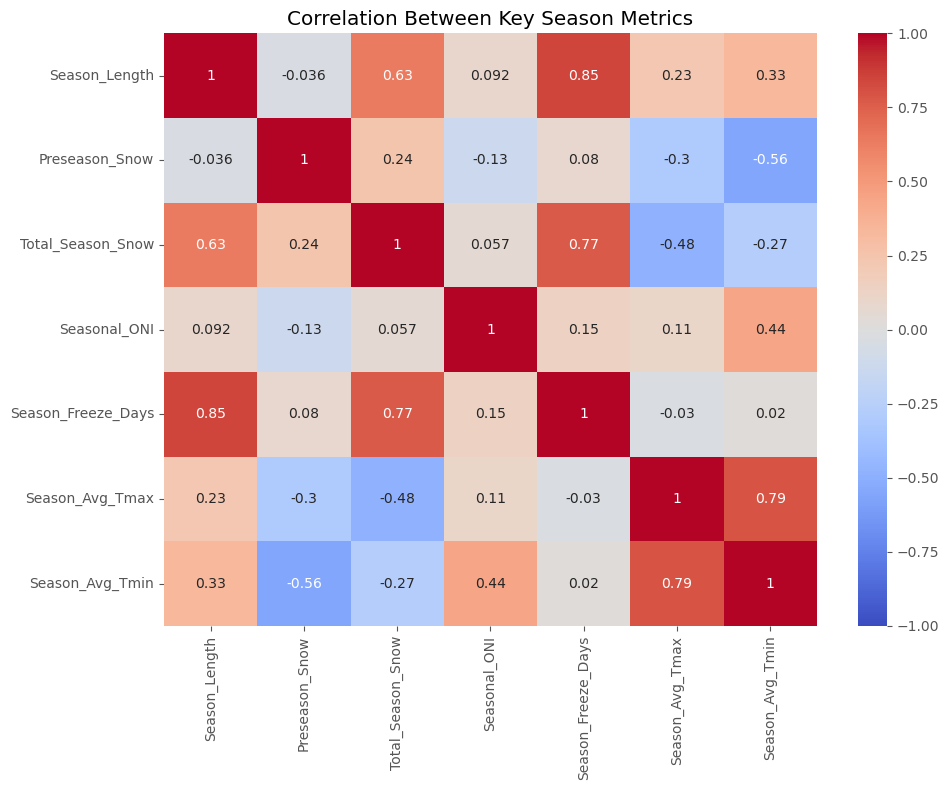


Data processing and model training complete!


In [153]:
# 21. Calculate correlation matrix for key metrics
correlation_cols = ['Season_Length', 'Preseason_Snow', 'Total_Season_Snow', 
                   'Seasonal_ONI', 'Season_Freeze_Days', 'Season_Avg_Tmax', 'Season_Avg_Tmin']
correlation = seasonal_df[correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Key Season Metrics')
plt.tight_layout()
plt.show()

print("\nData processing and model training complete!")